<h1> Notebook to prepare some plots/results analysis of the retrieval pipeline <h1>

In [ ]:
import pandas as pd
import numpy as np
import jieba
import seaborn as sns
import matplotlib.pyplot as plt
import glob

TARGET_LANGUAGES = ["en", "es", "de", "ar", "zh", "vi"]
MODELS = ["LaBSE", "bert-base-multilingual-cased", "distiluse-base-multilingual-cased", "paraphrase-multilingual-MiniLM-L12", "paraphrase-multilingual-mpnet-base", "xlm-roberta-base"]

In [ ]:
results = pd.read_csv("../data/retrieval_results/oasst2_filtered_distiluse-base-multilingual-cased-v2.csv", index_col=0)

In [ ]:
def calculate_fpr(results_df: pd.DataFrame, threshold: float=0.95) -> float:
    false_positives = (results_df["nearest_neighbor_score"] >= threshold).sum()
    false_positive_rate = np.round(false_positives / len(results_df), 3)
    return false_positive_rate * 100

In [ ]:
def count_shared_words_and_set(results):
    shared_words_count = []
    shared_words_list = []
    for index, row in results.iterrows():
        if row["lang"] == "zh" or row["nearest_neighbor_lang"] == "zh":
            answer_words = set(filter(lambda x: x.strip(), jieba.lcut(row["answer"])))
            neighbor_words = set(filter(lambda x: x.strip(), jieba.lcut(row["nearest_neighbor_text"])))
        else:
            answer_words = set(row["answer"].split())
            neighbor_words = set(row["nearest_neighbor_text"].split())
        shared_words = list(answer_words.intersection(neighbor_words))
        shared_words_count.append(len(shared_words))
        shared_words_list.append(shared_words)
    return shared_words_count, shared_words_list

In [ ]:
def correlation_nearest_neighbor_length_score(results):
    correlation = results["nearest_neighbor_text"].apply(lambda x: len(x.split(" "))).corr(results["nearest_neighbor_score"])
    return correlation

In [ ]:
def plot_correlation_shared_words_score(results):
    shared_words_count, shared_words_list = count_shared_words_and_set(results)
    results["shared_words_between_answer_and_neighbor"] = shared_words_count
    results["shared_words_between_answer_and_neighbor"] = shared_words_count
    sns.scatterplot(x="shared_words_between_answer_and_neighbor", y="nearest_neighbor_score", data=results, alpha=0.5)
    plt.xlabel("Number of shared words between candidate and nearest neighbor")
    plt.ylabel("Nearest Neighbor Score")
    plt.show()

In [ ]:
def plot_correlation_nearest_neighbor_length_score(results):
    results["neighbor_text_length"] = results["nearest_neighbor_text"].apply(lambda x: len(x.split(" ")))
    sns.scatterplot(x="neighbor_text_length", y="nearest_neighbor_score", data=results)
    plt.xlabel("Length of Nearest Neighbor Text")
    plt.ylabel ("Nearest Neighbor Score")
    plt.xlim(0, 500)
    plt.show()

In [ ]:
def plot_similarity_scores_by_language_overlay(results_df):
    plt.figure(figsize=(12, 8))
    sns.violinplot(x="lang", y="nearest_neighbor_score", hue="model", data=results_df, split=False, inner="quartile")
    plt.xlabel("Language")
    plt.ylabel("Similarity Score")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()


In [ ]:
def calculate_fpr_across_models(results_df, target_languages, target_models):
    thresholds = np.arange(0.1, 1.1, 0.1)
    fpr_data = []
    for model in target_models:
        for lang in target_languages:
            for threshold in thresholds:
                fpr = calculate_fpr(results_df[(results_df["lang"] == lang) & (results_df["model"] == model)], threshold)
                fpr_data.append({"model": model, "lang": lang, "threshold": threshold, "fpr": fpr})

    return pd.DataFrame(fpr_data)


In [ ]:
def fpr_for_specific_languages_models(results_df):
    fpr_data = []
    for model in results_df["model"].unique():
        for lang in results_df["lang"].unique():
            language_model_results = results_df[(results_df["lang"] == lang) & (results_df["model"] == model)]
            fpr = calculate_fpr(language_model_results)
            fpr_data.append({"model": model, "lang": lang, "fpr": fpr})

    return pd.DataFrame(fpr_data)

In [ ]:
def plot_fpr_rates_across_thresholds(fpr_df):
    g = sns.FacetGrid(fpr_df, col="lang", hue="model", col_wrap=3, height=4, aspect=1.5, sharey=False)
    g.map(sns.lineplot, "threshold", "fpr", marker="o")
    g.set_axis_labels("Threshold", "False Positive Rate (%)")
    g.set_titles("Language: {col_name}")
    g.set(xticks=np.arange(0.1, 1.1, 0.1))
    
    for axis in g.axes.flat:
        axis.tick_params(labelleft=True, labelbottom=True)
    
    plt.subplots_adjust(top=0.9)
    plt.legend(title="Model")
    g.figure.subplots_adjust(hspace=0.2, wspace=0.1)
    plt.xticks(np.arange(0.1, 1.1, 0.1))
    plt.xlim(0.095, 1)
    plt.show()


In [ ]:
def plot_language_fprs(fpr_df):
    g = sns.FacetGrid(fpr_df, col="model", col_wrap=3, height=4, aspect=1.5, sharey=False)
    g.map_dataframe(sns.barplot, x="lang", y="fpr", dodge=False)
    g.set_axis_labels("Language", "False Positive Rate (%)")
    g.set_titles("Model: {col_name}")
    
    for axis in g.axes.flat:
        axis.tick_params(labelleft=True, labelbottom=True)
        
    plt.subplots_adjust(top=0.9, right=0.8)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_different_language_neighbors(language_percentages_df):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=language_percentages_df, x="lang", y="percentage", hue="model", palette="Paired")
    plt.xlabel("Language")
    plt.ylabel("Percentage of neighbors in different language")
    plt.ylim(0, 100)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [ ]:
def percentage_different_language_nearest_neighbor(results_df):
    language_percentages = []
    for model in results_df["model"].unique():
        model_results = results_df[results_df["model"] == model]
        for lang in model_results["lang"].unique():
            language_results = model_results[model_results["lang"] == lang]
            different_language_count = sum(language_results["lang"] != language_results["nearest_neighbor_lang"])
            total_count = len(language_results)
            percentage = (different_language_count / total_count) * 100
            language_percentages.append({"lang": lang, "model": model, "percentage": percentage})
    
    return pd.DataFrame(language_percentages)

### Correlations

In [ ]:
plot_correlation_nearest_neighbor_length_score(results)

In [ ]:
plot_correlation_shared_words_score(results)

In [ ]:
correlation_nearest_neighbor_length_score(results)

<h1> Visualizations of OASST2 evaluation <h1>

In [ ]:
datasets = glob.glob("../data/retrieval_results/oasst2*.csv")
dfs = []
for dataset, model in zip(datasets, MODELS):
    print(dataset, model)
    df = pd.read_csv(dataset, index_col=0)
    df["model"] = model
    dfs.append(df)

In [ ]:
full_results_oasst = pd.concat(dfs)
full_results_oasst.reset_index(drop=True, inplace=True)

<h2> Distribution of similarity scores across languages <h2>

In [ ]:
plot_similarity_scores_by_language_overlay(full_results_oasst)

<h2> FPR across different languages, models, and thresholds (acceptable FPR = 1%) <h2>

In [ ]:
fpr_df_models = calculate_fpr_across_models(full_results_oasst, TARGET_LANGUAGES, MODELS)
plot_fpr_rates_across_thresholds(fpr_df_models)

<h2> FPR across different languages and models <h2>

In [ ]:
fpr_df_languages_models = fpr_for_specific_languages_models(full_results_oasst)
plot_language_fprs(fpr_df_languages_models)

<h2> Percentange of situations where nearest neigbhor was in different language than original text <h2>

In [ ]:
language_percentages_df = percentage_different_language_nearest_neighbor(full_results_oasst)
plot_different_language_neighbors(language_percentages_df)

<h1> Visualizations of MLQA evaluation <h1>

In [40]:
datasets = glob.glob("../data/retrieval_results/mlqa*.csv")
dfs = []
for dataset, model in zip(datasets, MODELS):
    print(dataset, model)
    df = pd.read_csv(dataset, index_col=0)
    df["model"] = model
    dfs.append(df)

../data/retrieval_results/mlqa_filtered_LaBSE.csv LaBSE
../data/retrieval_results/mlqa_filtered_bert-base-multilingual-cased.csv bert-base-multilingual-cased
../data/retrieval_results/mlqa_filtered_distiluse-base-multilingual-cased-v2.csv distiluse-base-multilingual-cased
../data/retrieval_results/mlqa_filtered_paraphrase-multilingual-MiniLM-L12-v2.csv paraphrase-multilingual-MiniLM-L12
../data/retrieval_results/mlqa_filtered_paraphrase-multilingual-mpnet-base-v2.csv paraphrase-multilingual-mpnet-base
../data/retrieval_results/mlqa_filtered_xlm-roberta-base.csv xlm-roberta-base


In [42]:
full_results_mlqa = pd.concat(dfs)
full_results_mlqa.reset_index(drop=True, inplace=True)

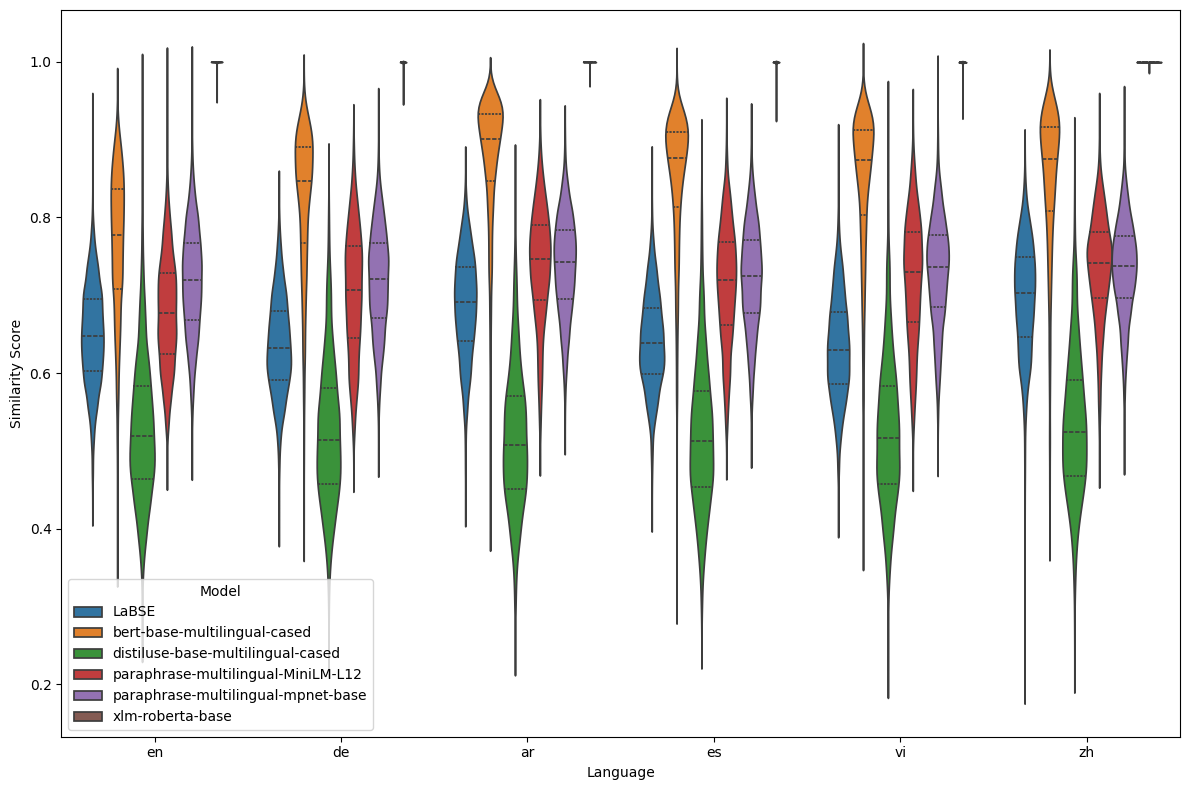

In [43]:
plot_similarity_scores_by_language_overlay(full_results_mlqa)

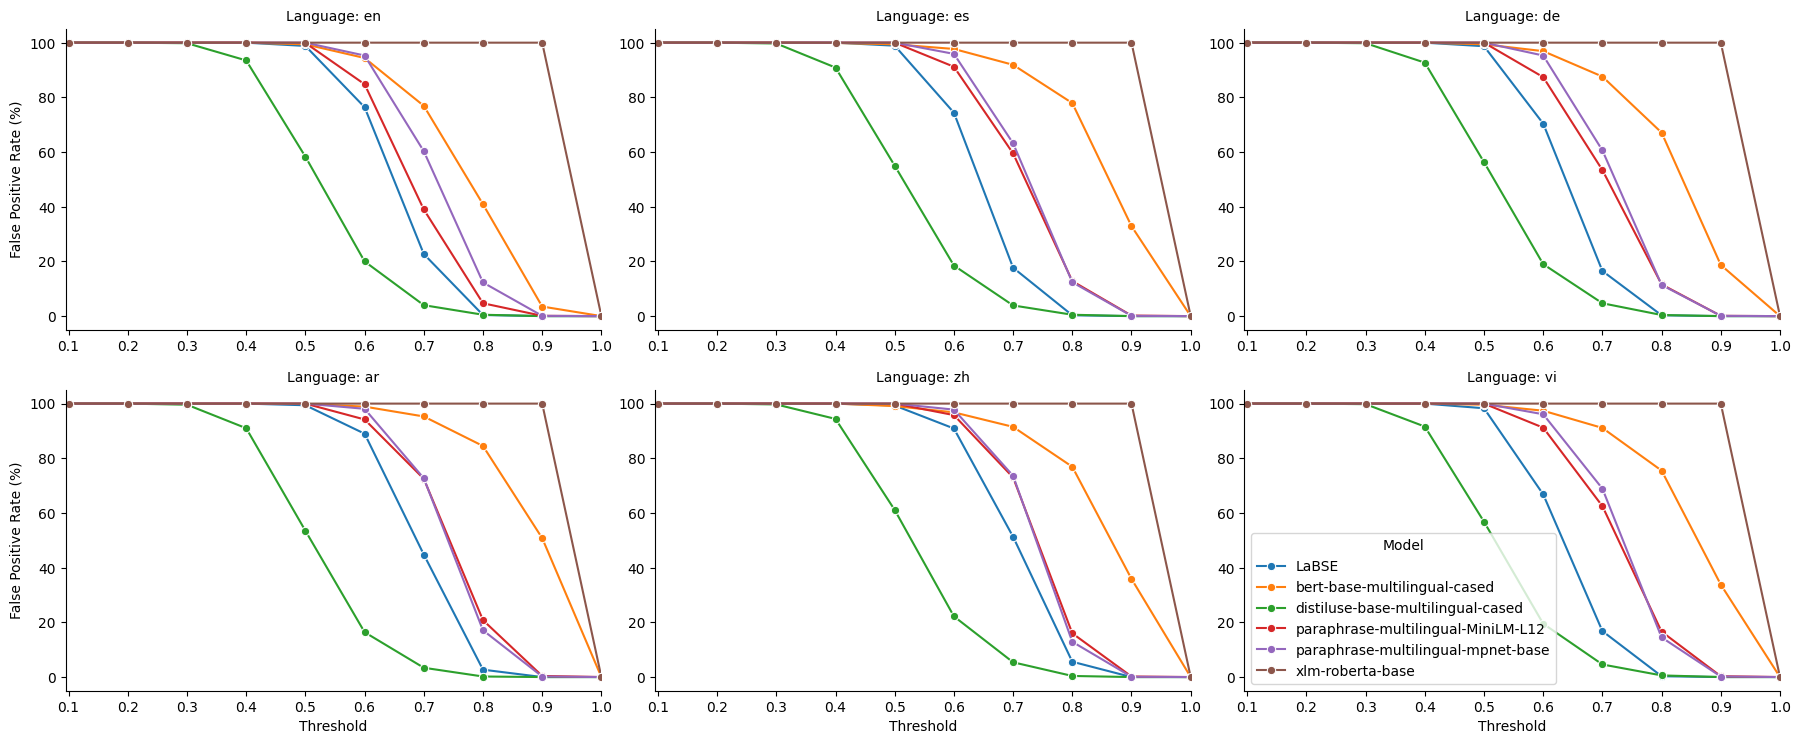

In [44]:
fpr_df_models = calculate_fpr_across_models(full_results_mlqa, TARGET_LANGUAGES, MODELS)
plot_fpr_rates_across_thresholds(fpr_df_models)

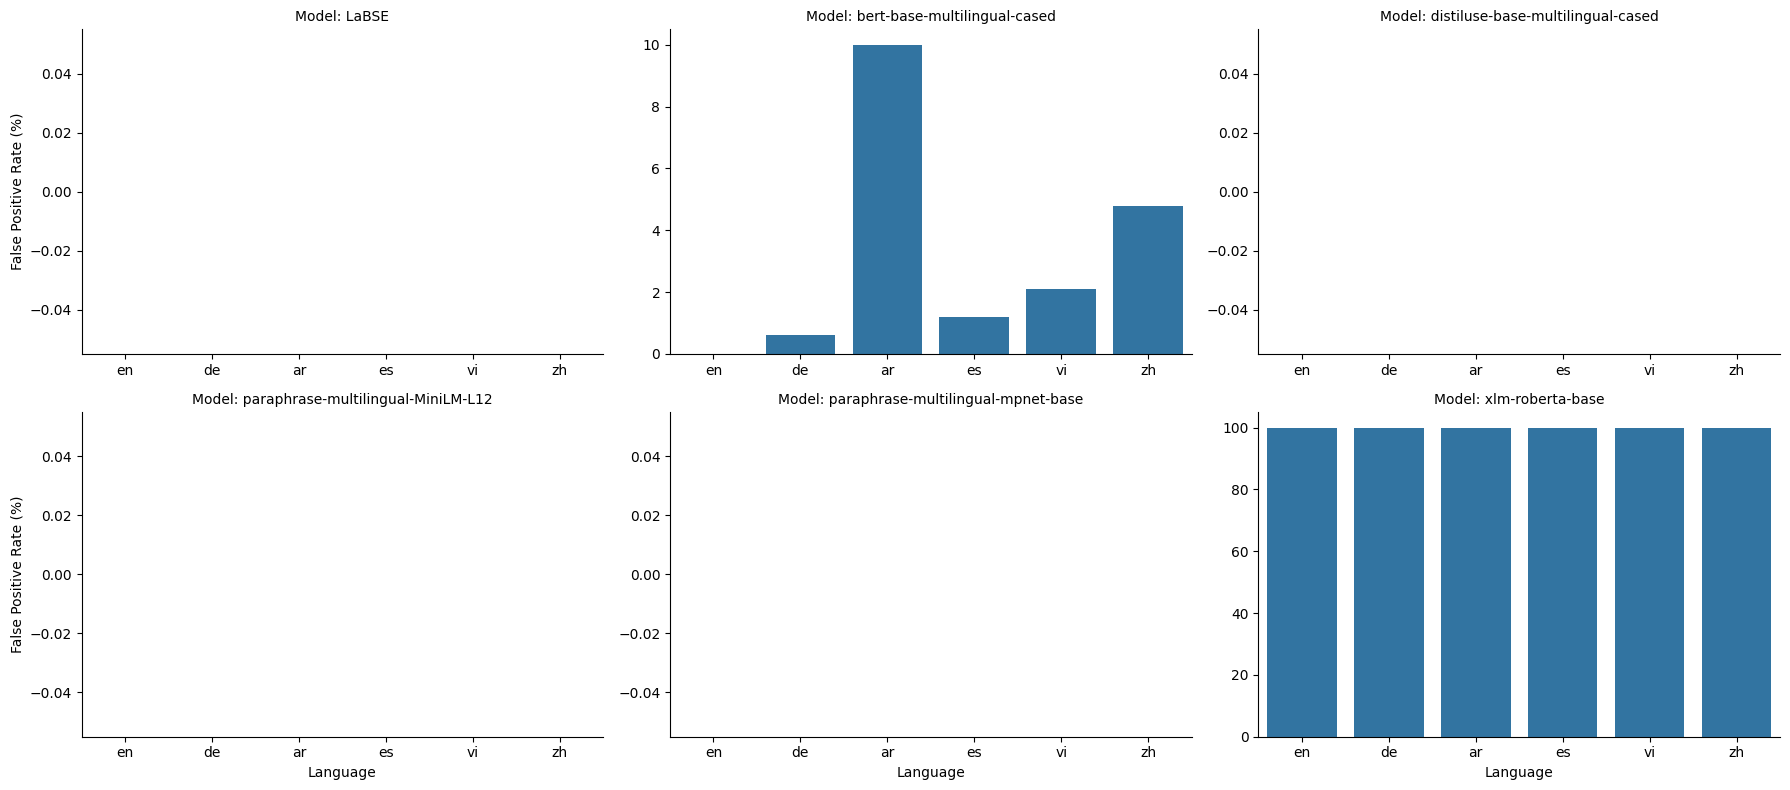

In [45]:
fpr_df_languages_models = fpr_for_specific_languages_models(full_results_mlqa)
plot_language_fprs(fpr_df_languages_models)

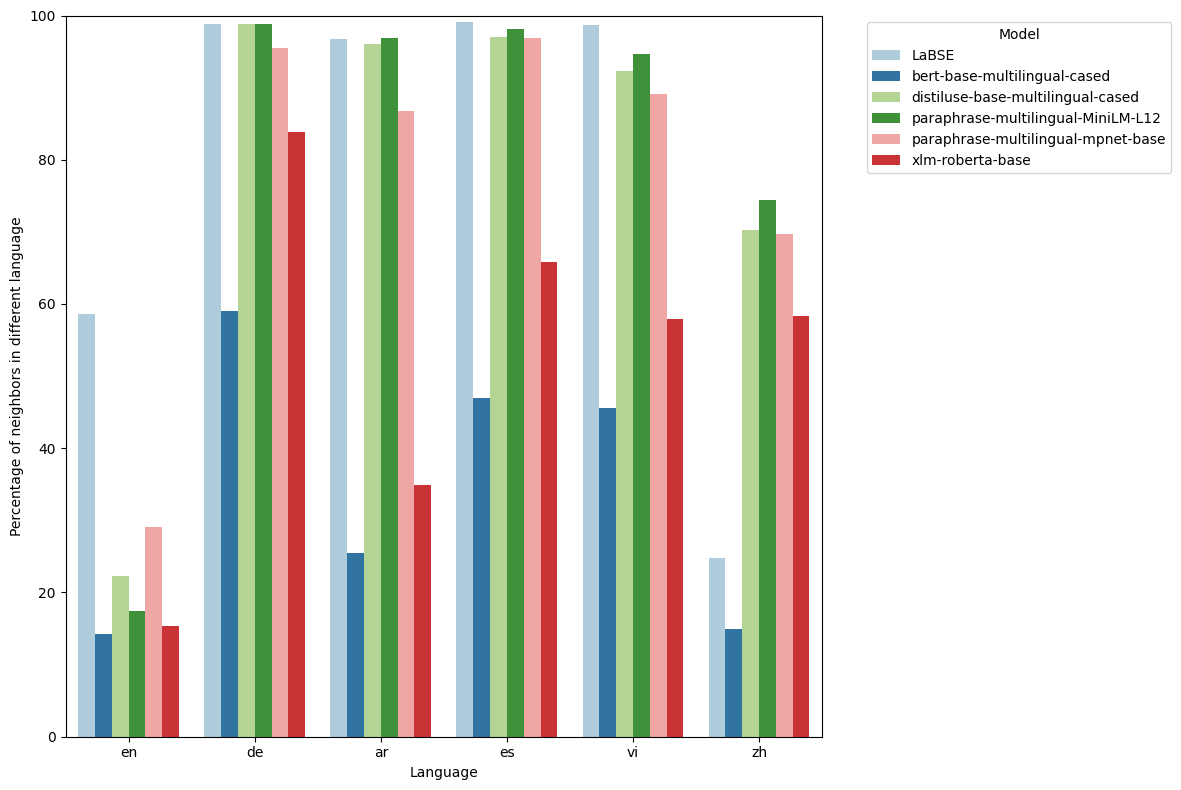

In [46]:
language_percentages_df = percentage_different_language_nearest_neighbor(full_results_mlqa)
plot_different_language_neighbors(language_percentages_df)

<h1> Visualizations of MKQA evaluation <h1>

In [39]:
datasets = glob.glob("../data/retrieval_results/mkqa*.csv")
dfs = []
for dataset, model in zip(datasets, MODELS):
    print(dataset, model)
    df = pd.read_csv(dataset, index_col=0)
    df["model"] = model
    dfs.append(df)

../data/retrieval_results/mkqa_filtered_LaBSE.csv LaBSE
../data/retrieval_results/mkqa_filtered_bert-base-multilingual-cased.csv bert-base-multilingual-cased
../data/retrieval_results/mkqa_filtered_distiluse-base-multilingual-cased-v2.csv distiluse-base-multilingual-cased
../data/retrieval_results/mkqa_filtered_paraphrase-multilingual-MiniLM-L12-v2.csv paraphrase-multilingual-MiniLM-L12
../data/retrieval_results/mkqa_filtered_paraphrase-multilingual-mpnet-base-v2.csv paraphrase-multilingual-mpnet-base
../data/retrieval_results/mkqa_filtered_xlm-roberta-base.csv xlm-roberta-base


In [48]:
full_results_mkqa = pd.concat(dfs)
full_results_mkqa.reset_index(drop=True, inplace=True)

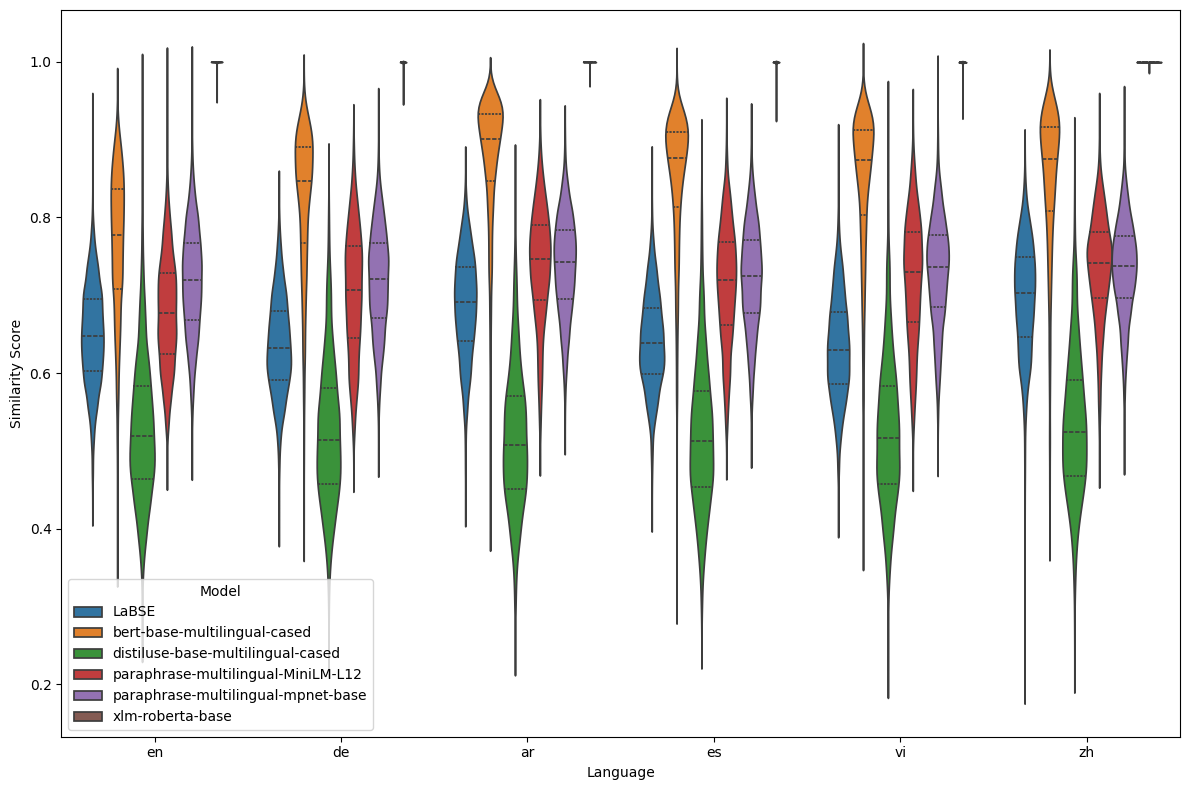

In [49]:
plot_similarity_scores_by_language_overlay(full_results_mlqa)

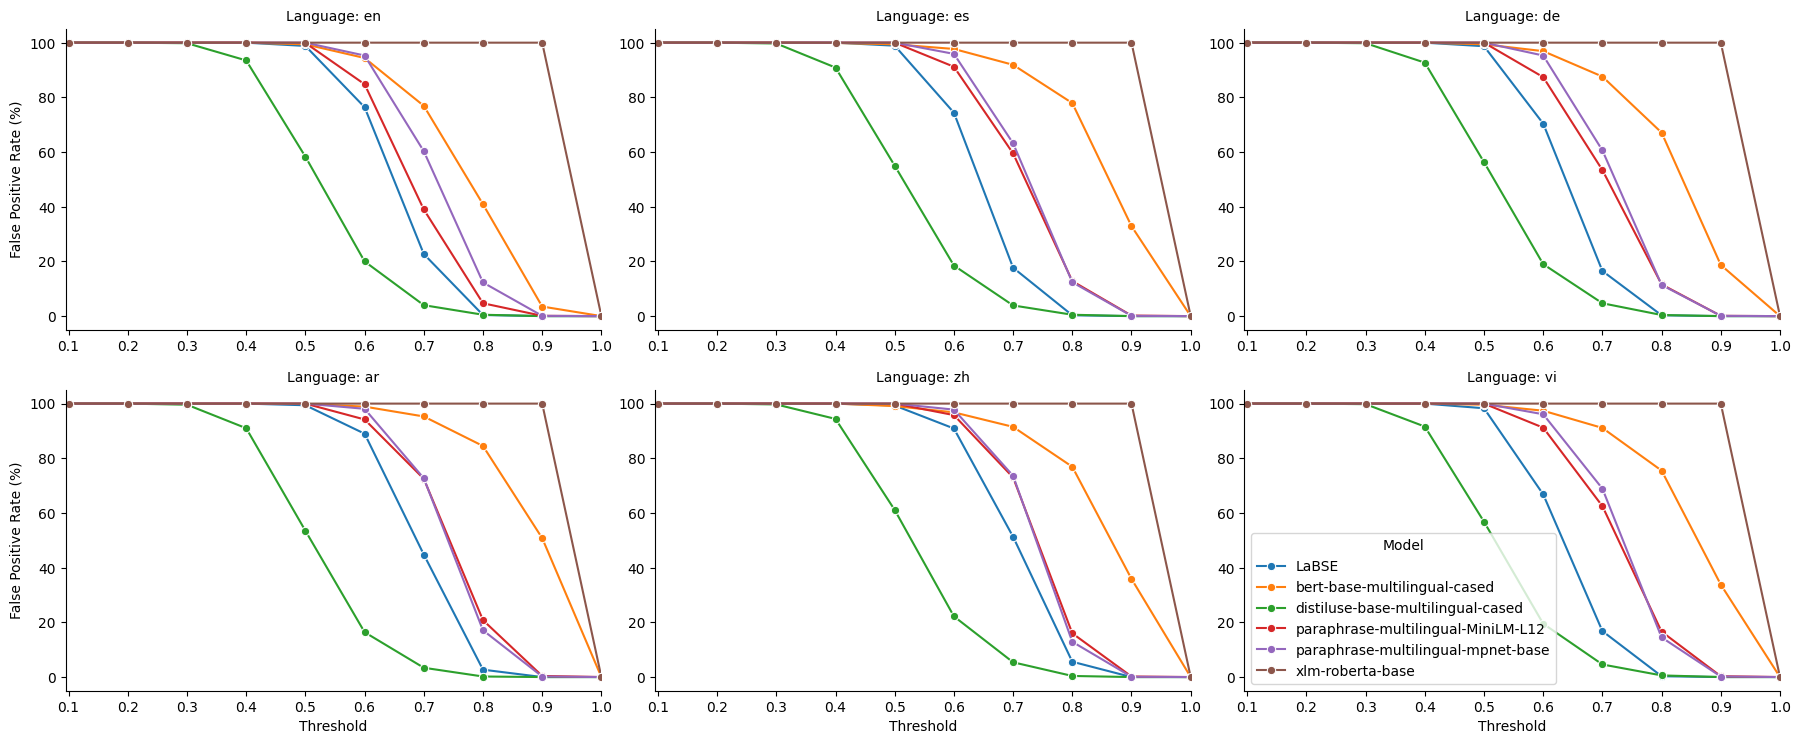

In [50]:
fpr_df_models = calculate_fpr_across_models(full_results_mlqa, TARGET_LANGUAGES, MODELS)
plot_fpr_rates_across_thresholds(fpr_df_models)

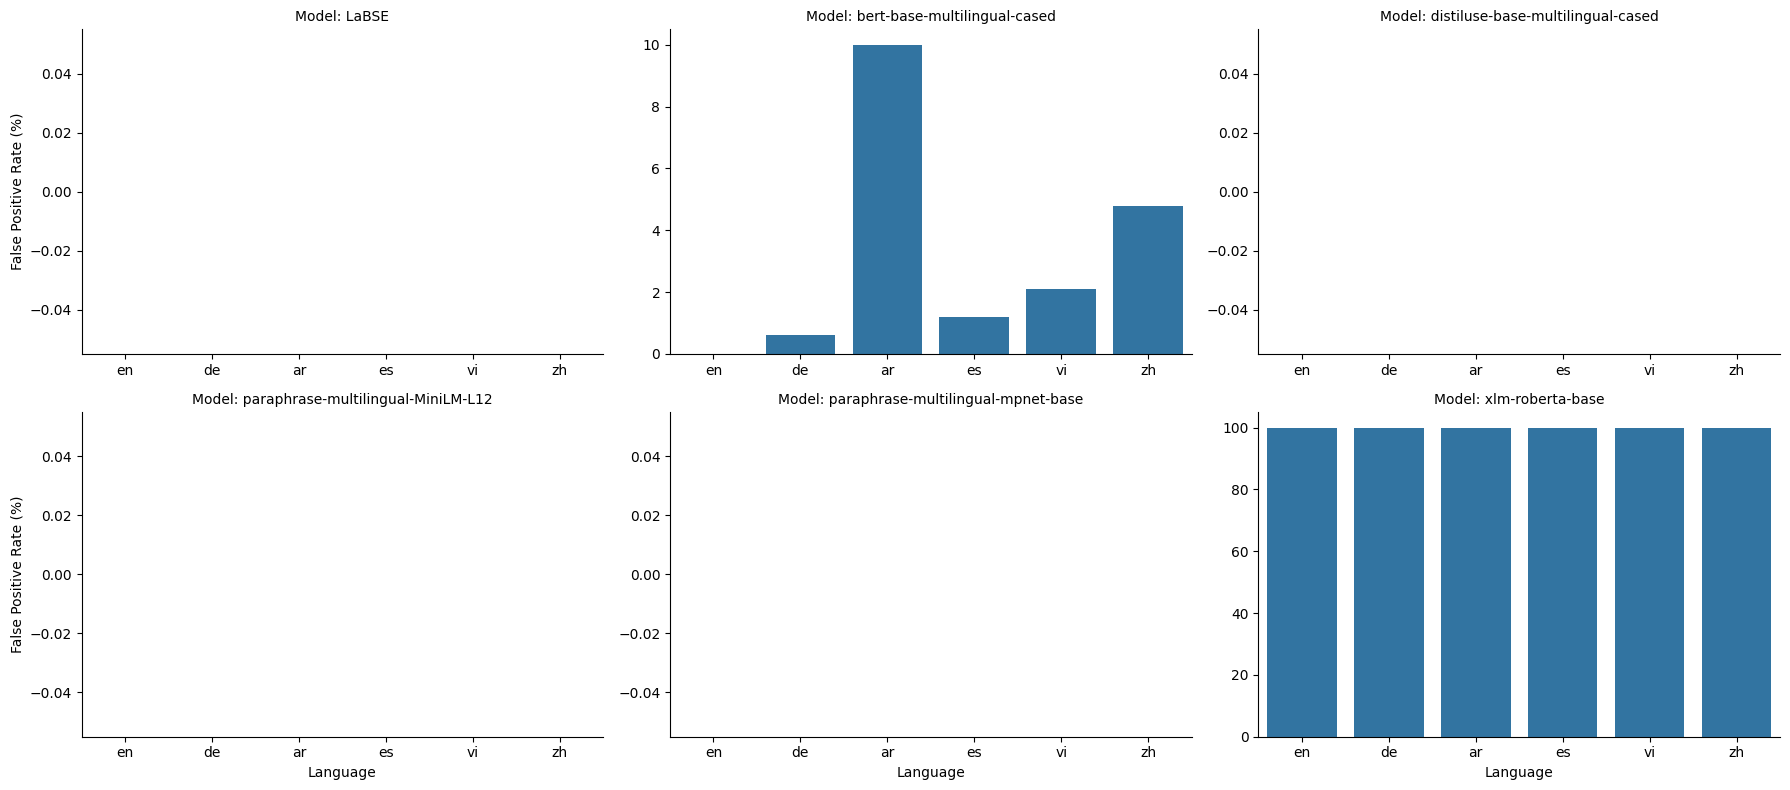

In [51]:
fpr_df_languages_models = fpr_for_specific_languages_models(full_results_mlqa)
plot_language_fprs(fpr_df_languages_models)

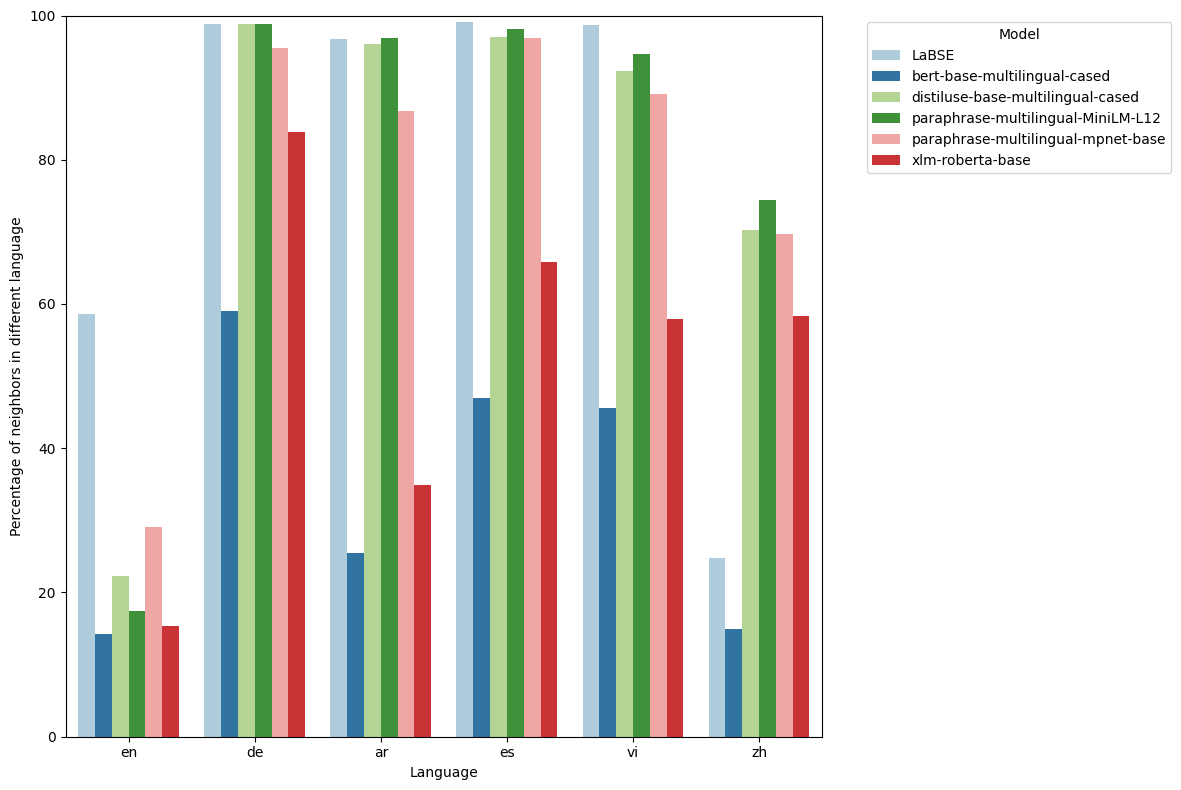

In [52]:
language_percentages_df = percentage_different_language_nearest_neighbor(full_results_mlqa)
plot_different_language_neighbors(language_percentages_df)